<div style="float:left"><h1> Image Cap</h1></div><br>
<div style="float:left"><h2> Generate caption from Images using neural network</h2></div>
<div style="float:right"><h3> Varsha Rai </h3></div>

### Table of contents: <br>
* 1.[Define data path](#t1)
* 2.[Create Data Frame for captions](#t2)
* 3.[Data Cleaning](#t3)
* 4.[Load the CNN model with transfer learning](#t4)
* 5.[Define Encoder](#t5)
* 6.[Create image feature vectors](#t6)
* 7.[Create data frame for image feature vectors](#t7)
* 8.[Process the words from captions](#t8)
* 9.[Load the GloVe Model](#t9)
* 10.[Create matrix using weights of GloVe model](#t10)
* 11.[Merge the image vector with word vector to predict the probability for next word](#t11)
* 12.[Train the model](#t12)
* 13.[Predict the Caption](#t13)
* 14.[Evaluate the model output](#t14)
* 15.[Conclusion](#t15)

In [61]:
# Import useful libraries

import numpy as np
import pandas as pd
import random
import glob2

import os
from collections import Counter

from keras.preprocessing import sequence
from keras.layers import LSTM, Embedding, Dense, Activation, Reshape, Dropout
from keras.optimizers import Adam
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.preprocessing import image
from keras import Input
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model

from nltk.translate.bleu_score import corpus_bleu

import re
import json
import pickle

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# To display maximum lenght of column, rows and widht
pd.set_option("display.max_rows", None) # for row
pd.set_option("display.max_columns", None) # for column
pd.set_option('display.max_colwidth', None) # for col width

<a id="t1"></a>

### Define the path to access data

In [3]:
# Define data path to access image and captions
data_path = os.path.dirname(os.path.abspath('.')) + "\\data\\"
data_path

'C:\\Users\\varsh\\Desktop\\brain_station\\capstone\\data\\'

In [4]:
# Load the training captions from the given path
captions_path = data_path + "\\annotations_trainval2017\\annotations\\captions_train2017.json"
with open(captions_path) as f:
    train_captions = json.load(f)

In [5]:
# Load the validation captions from the given path
val_captions_path = data_path + "\\annotations_trainval2017\\annotations\\captions_val2017.json"
with open(val_captions_path) as f:
    val_captions = json.load(f)

Annotations file is JSON type, it has info stored in dictionary form. By accessing the key-value pair, I can extract information and put them into data frame for easy access. For this assignment data set has around 45 gb of data. In case, I want to continue to work on Google Colab, I can access the images using URL. Here, I am not using URL, because I can access the images directly form the folder where they are stored and that will be less computationally expensive in comparison to accessing through URL
So for now I am just keeping the code, in case required.

<a id="t2"></a>

### Put the data into data frame

In [6]:
# From the json file extract image url with image id for test data set 
# Alog with image url it has other info like license, hieght, width etc but that is not required therefore I will drop them and keep only coco url
img_url_df = pd.DataFrame(train_captions['images']).drop(['license', 'height', 'width', 'date_captured', 'flickr_url', 'id'], axis=1)

# From image id remove ".jpg"
img_url_df['file_name'] = img_url_df['file_name'].str.replace('.jpg', '')

# Rename the column
img_url_df = img_url_df.rename(columns={'file_name': 'image_id'})

# Display the df created
img_url_df.head()

image_id                                                  coco_url
0  000000391895  http://images.cocodataset.org/train2017/000000391895.jpg
1  000000522418  http://images.cocodataset.org/train2017/000000522418.jpg
2  000000184613  http://images.cocodataset.org/train2017/000000184613.jpg
3  000000318219  http://images.cocodataset.org/train2017/000000318219.jpg
4  000000554625  http://images.cocodataset.org/train2017/000000554625.jpg

In [7]:
# From the json file extract image url with image id for validation data set
# Alog with image url it has other info like license, hieght, width etc but that is not required therefore I will drop them and keep only coco url
val_img_url_df = pd.DataFrame(val_captions['images']).drop(['license', 'height', 'width', 'date_captured', 'flickr_url', 'id'], axis=1)

# From image id remove ".jpg"
val_img_url_df['file_name'] = val_img_url_df['file_name'].str.replace('.jpg', '')

# Rename the column
val_img_url_df = val_img_url_df.rename(columns={'file_name': 'image_id'})

# Display the df created
val_img_url_df.head()

image_id                                                coco_url
0  000000397133  http://images.cocodataset.org/val2017/000000397133.jpg
1  000000037777  http://images.cocodataset.org/val2017/000000037777.jpg
2  000000252219  http://images.cocodataset.org/val2017/000000252219.jpg
3  000000087038  http://images.cocodataset.org/val2017/000000087038.jpg
4  000000174482  http://images.cocodataset.org/val2017/000000174482.jpg

In [8]:
# Extract the image id and captions of traing data set from the loaded json file & put that into data frame
df = pd.DataFrame.from_dict(train_captions["annotations"])

# Display the df created
df.head()

image_id   id  \
0    203564   37   
1    322141   49   
2     16977   89   
3    106140   98   
4    106140  101   

                                                               caption  
0                   A bicycle replica with a clock as the front wheel.  
1                    A room with blue walls and a white sink and door.  
2  A car that seems to be parked illegally behind a legally parked car  
3                   A large passenger airplane flying through the air.  
4              There is a GOL plane taking off in a partly cloudy sky.

In [9]:
# Extract the image id and captions of validation data set from the loaded json file & put that into data frame
val_df = pd.DataFrame.from_dict(val_captions["annotations"])

# Display the df created
val_df.head()

image_id   id                                                    caption
0    179765   38      A black Honda motorcycle parked in front of a garage.
1    179765  182              A Honda motorcycle parked in a grass driveway
2    190236  401  An office cubicle with four different types of computers.
3    331352  441                  A small closed toilet in a cramped space.
4    517069  447             Two women waiting at a bench next to a street.

In [10]:
# Every image has 5 associated captions with that
# Put all the caption related to one image together as list for train data set
annotation_df = df.groupby('image_id').agg({'caption': list})

# Display the df created
annotation_df.head()

caption
image_id                                                                                                                                                                                                                                                                                                                                                                                                        
9                                                                                                                         [Closeup of bins of food that include broccoli and bread., A meal is presented in brightly colored plastic trays., there are containers filled with different kinds of foods, Colorful dishes holding meat, vegetables, fruit, and bread., A bunch of trays that have different food.]
25                                                                                                                                                                  [A giraffe eating food from the top of the tree., A giraffe standing up nearby a tree , A giraffe mother with its baby in the forest., Two giraffes standing in a tree filled area., A giraffe standing next to a forest filled with trees.]
30                                                                                                                                     [A flower vase is sitting on a porch stand., White vase with different colored flowers sitting inside of it. , a white vase with many flowers on a stage, A white vase filled with different colored flowers., A vase with red and white flowers outside on a sunny day.]
34                                                                                                                                                                 [A zebra grazing on lush green grass in a field., Zebra reaching its head down to ground where grass is. , The zebra is eating grass in the sun., A lone zebra grazing in some green grass., a Zebra grazing on grass in a green open field.]
36        [Woman in swim suit holding parasol on sunny day., A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind., A woman in a floral swimsuit holds a pink umbrella., A woman with an umbrella near the sea, A girl in a bathing suit with a pink umbrella.]

In [11]:
# Every image has 5 associated captions with that
# Put all the caption related to one image together as list for validation data set
val_annotation_df = val_df.groupby('image_id').agg({'caption': list})

# Display the df created
val_annotation_df.head()

caption
image_id                                                                                                                                                                                                                                                                     
139                                       [A woman stands in the dining area at the table., A room with chairs, a table, and a woman in it., A woman standing in a kitchen by a window, A person standing at a table in a room., A living area with a television and a table]
285                          [A big burly grizzly bear is show with grass in the background., The large brown bear has a black nose., Closeup of a brown bear sitting in a grassy area., A large bear that is sitting on grass. , A close up picture of a brown bear's face.]
632       [Bedroom scene with a bookcase, blue comforter and window., A bedroom with a bookshelf full of books., This room has a bed with blue sheets and a large bookcase, A bed and a mirror in a small room., a bed room with a neatly made bed a window and a book shelf]
724                                  [A stop sign is mounted upside-down on it's post. , A stop sign that is hanging upside down., An upside down stop sign by the road., a stop sign put upside down on a metal pole , A stop sign installed upside down on a street corner]
776         [Three teddy bears, each a different color, snuggling together., Three stuffed animals are sitting on a bed. , three teddy bears giving each other a hug, A group of three stuffed animal teddy bears., Three stuffed bears hugging and sitting on a blue pillow]

In [12]:
# Rest the index of train data set
train_df = annotation_df.reset_index()
train_df.head()

image_id  \
0         9   
1        25   
2        30   
3        34   
4        36   

                                                                                                                                                                                                                                                                                                                                                                                                  caption  
0                                                                                                                  [Closeup of bins of food that include broccoli and bread., A meal is presented in brightly colored plastic trays., there are containers filled with different kinds of foods, Colorful dishes holding meat, vegetables, fruit, and bread., A bunch of trays that have different food.]  
1                                                                                                                                                            [A giraffe eating food from the top of the tree., A giraffe standing up nearby a tree , A giraffe mother with its baby in the forest., Two giraffes standing in a tree filled area., A giraffe standing next to a forest filled with trees.]  
2                                                                                                                               [A flower vase is sitting on a porch stand., White vase with different colored flowers sitting inside of it. , a white vase with many flowers on a stage, A white vase filled with different colored flowers., A vase with red and white flowers outside on a sunny day.]  
3                                                                                                                                                           [A zebra grazing on lush green grass in a field., Zebra reaching its head down to ground where grass is. , The zebra is eating grass in the sun., A lone zebra grazing in some green grass., a Zebra grazing on grass in a green open field.]  
4  [Woman in swim suit holding parasol on sunny day., A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind., A woman in a floral swimsuit holds a pink umbrella., A woman with an umbrella near the sea, A girl in a bathing suit with a pink umbrella.]

In [13]:
# Reset the index of validation data set
val_df = val_annotation_df.reset_index()
val_df.head()

image_id  \
0       139   
1       285   
2       632   
3       724   
4       776   

                                                                                                                                                                                                                                                               caption  
0                                  [A woman stands in the dining area at the table., A room with chairs, a table, and a woman in it., A woman standing in a kitchen by a window, A person standing at a table in a room., A living area with a television and a table]  
1                     [A big burly grizzly bear is show with grass in the background., The large brown bear has a black nose., Closeup of a brown bear sitting in a grassy area., A large bear that is sitting on grass. , A close up picture of a brown bear's face.]  
2  [Bedroom scene with a bookcase, blue comforter and window., A bedroom with a bookshelf full of books., This room has a bed with blue sheets and a large bookcase, A bed and a mirror in a small room., a bed room with a neatly made bed a window and a book shelf]  
3                             [A stop sign is mounted upside-down on it's post. , A stop sign that is hanging upside down., An upside down stop sign by the road., a stop sign put upside down on a metal pole , A stop sign installed upside down on a street corner]  
4    [Three teddy bears, each a different color, snuggling together., Three stuffed animals are sitting on a bed. , three teddy bears giving each other a hug, A group of three stuffed animal teddy bears., Three stuffed bears hugging and sitting on a blue pillow]

In [14]:
# Check the data type of train set
train_df.dtypes

image_id     int64
caption     object
dtype: object

In [15]:
# Check the data type of validation set
val_df.dtypes

image_id     int64
caption     object
dtype: object

<a id="t3"></a>

### Cleaning of data

In [16]:
# Captions needed data cleaning for uniformity
# Replace anything except a-z with a space (i.e. special character, digits etc)
train_df['caption'] = train_df['caption'].apply(lambda x: [re.sub(r"[^a-z]", " ", y.lower()) for y in x])
train_df.head()

image_id  \
0         9   
1        25   
2        30   
3        34   
4        36   

                                                                                                                                                                                                                                                                                                                                                                                                  caption  
0                                                                                                                  [closeup of bins of food that include broccoli and bread , a meal is presented in brightly colored plastic trays , there are containers filled with different kinds of foods, colorful dishes holding meat  vegetables  fruit  and bread , a bunch of trays that have different food ]  
1                                                                                                                                                            [a giraffe eating food from the top of the tree , a giraffe standing up nearby a tree , a giraffe mother with its baby in the forest , two giraffes standing in a tree filled area , a giraffe standing next to a forest filled with trees ]  
2                                                                                                                               [a flower vase is sitting on a porch stand , white vase with different colored flowers sitting inside of it  , a white vase with many flowers on a stage, a white vase filled with different colored flowers , a vase with red and white flowers outside on a sunny day ]  
3                                                                                                                                                           [a zebra grazing on lush green grass in a field , zebra reaching its head down to ground where grass is  , the zebra is eating grass in the sun , a lone zebra grazing in some green grass , a zebra grazing on grass in a green open field ]  
4  [woman in swim suit holding parasol on sunny day , a woman posing for the camera  holding a pink  open umbrella and wearing a bright  floral  ruched bathing suit  by a life guard stand with lake  green trees  and a blue sky with a few clouds behind , a woman in a floral swimsuit holds a pink umbrella , a woman with an umbrella near the sea, a girl in a bathing suit with a pink umbrella ]

In [17]:
# Remove full-stop, leading trailing white space from all the captions
train_df['caption'] = train_df['caption'].apply(lambda x: [y.rstrip('.').strip() for y in x])
train_df.head()

image_id  \
0         9   
1        25   
2        30   
3        34   
4        36   

                                                                                                                                                                                                                                                                                                                                                                                              caption  
0                                                                                                                  [closeup of bins of food that include broccoli and bread, a meal is presented in brightly colored plastic trays, there are containers filled with different kinds of foods, colorful dishes holding meat  vegetables  fruit  and bread, a bunch of trays that have different food]  
1                                                                                                                                                             [a giraffe eating food from the top of the tree, a giraffe standing up nearby a tree, a giraffe mother with its baby in the forest, two giraffes standing in a tree filled area, a giraffe standing next to a forest filled with trees]  
2                                                                                                                                [a flower vase is sitting on a porch stand, white vase with different colored flowers sitting inside of it, a white vase with many flowers on a stage, a white vase filled with different colored flowers, a vase with red and white flowers outside on a sunny day]  
3                                                                                                                                                             [a zebra grazing on lush green grass in a field, zebra reaching its head down to ground where grass is, the zebra is eating grass in the sun, a lone zebra grazing in some green grass, a zebra grazing on grass in a green open field]  
4  [woman in swim suit holding parasol on sunny day, a woman posing for the camera  holding a pink  open umbrella and wearing a bright  floral  ruched bathing suit  by a life guard stand with lake  green trees  and a blue sky with a few clouds behind, a woman in a floral swimsuit holds a pink umbrella, a woman with an umbrella near the sea, a girl in a bathing suit with a pink umbrella]

In [18]:
# Replace multiple white spaces with single space
train_df['caption'] = train_df['caption'].apply(lambda x: [re.sub(r'\s+', ' ',y) for y in x])
train_df.head()

image_id  \
0         9   
1        25   
2        30   
3        34   
4        36   

                                                                                                                                                                                                                                                                                                                                                                                       caption  
0                                                                                                              [closeup of bins of food that include broccoli and bread, a meal is presented in brightly colored plastic trays, there are containers filled with different kinds of foods, colorful dishes holding meat vegetables fruit and bread, a bunch of trays that have different food]  
1                                                                                                                                                      [a giraffe eating food from the top of the tree, a giraffe standing up nearby a tree, a giraffe mother with its baby in the forest, two giraffes standing in a tree filled area, a giraffe standing next to a forest filled with trees]  
2                                                                                                                         [a flower vase is sitting on a porch stand, white vase with different colored flowers sitting inside of it, a white vase with many flowers on a stage, a white vase filled with different colored flowers, a vase with red and white flowers outside on a sunny day]  
3                                                                                                                                                      [a zebra grazing on lush green grass in a field, zebra reaching its head down to ground where grass is, the zebra is eating grass in the sun, a lone zebra grazing in some green grass, a zebra grazing on grass in a green open field]  
4  [woman in swim suit holding parasol on sunny day, a woman posing for the camera holding a pink open umbrella and wearing a bright floral ruched bathing suit by a life guard stand with lake green trees and a blue sky with a few clouds behind, a woman in a floral swimsuit holds a pink umbrella, a woman with an umbrella near the sea, a girl in a bathing suit with a pink umbrella]

Image id in data folder or in URL is 12-digit long. But if we take a look on image id in annotation file, it has image id between 2 to 12. To bring the uniformity zero padding is performed.

In [19]:
# Zero padding to make all the image_id uniform with 12 digits each on train data set
train_df['image_id'] = train_df['image_id'].apply(lambda x: '{0:0>12}'.format(x))
train_df.head()

image_id  \
0  000000000009   
1  000000000025   
2  000000000030   
3  000000000034   
4  000000000036   

                                                                                                                                                                                                                                                                                                                                                                                       caption  
0                                                                                                              [closeup of bins of food that include broccoli and bread, a meal is presented in brightly colored plastic trays, there are containers filled with different kinds of foods, colorful dishes holding meat vegetables fruit and bread, a bunch of trays that have different food]  
1                                                                                                                                                      [a giraffe eating food from the top of the tree, a giraffe standing up nearby a tree, a giraffe mother with its baby in the forest, two giraffes standing in a tree filled area, a giraffe standing next to a forest filled with trees]  
2                                                                                                                         [a flower vase is sitting on a porch stand, white vase with different colored flowers sitting inside of it, a white vase with many flowers on a stage, a white vase filled with different colored flowers, a vase with red and white flowers outside on a sunny day]  
3                                                                                                                                                      [a zebra grazing on lush green grass in a field, zebra reaching its head down to ground where grass is, the zebra is eating grass in the sun, a lone zebra grazing in some green grass, a zebra grazing on grass in a green open field]  
4  [woman in swim suit holding parasol on sunny day, a woman posing for the camera holding a pink open umbrella and wearing a bright floral ruched bathing suit by a life guard stand with lake green trees and a blue sky with a few clouds behind, a woman in a floral swimsuit holds a pink umbrella, a woman with an umbrella near the sea, a girl in a bathing suit with a pink umbrella]

In [20]:
# Zero padding to make all the image_id uniform with 12 digits each on validation data set
val_df['image_id'] = val_df['image_id'].apply(lambda x: '{0:0>12}'.format(x))
val_df.head()

image_id  \
0  000000000139   
1  000000000285   
2  000000000632   
3  000000000724   
4  000000000776   

                                                                                                                                                                                                                                                               caption  
0                                  [A woman stands in the dining area at the table., A room with chairs, a table, and a woman in it., A woman standing in a kitchen by a window, A person standing at a table in a room., A living area with a television and a table]  
1                     [A big burly grizzly bear is show with grass in the background., The large brown bear has a black nose., Closeup of a brown bear sitting in a grassy area., A large bear that is sitting on grass. , A close up picture of a brown bear's face.]  
2  [Bedroom scene with a bookcase, blue comforter and window., A bedroom with a bookshelf full of books., This room has a bed with blue sheets and a large bookcase, A bed and a mirror in a small room., a bed room with a neatly made bed a window and a book shelf]  
3                             [A stop sign is mounted upside-down on it's post. , A stop sign that is hanging upside down., An upside down stop sign by the road., a stop sign put upside down on a metal pole , A stop sign installed upside down on a street corner]  
4    [Three teddy bears, each a different color, snuggling together., Three stuffed animals are sitting on a bed. , three teddy bears giving each other a hug, A group of three stuffed animal teddy bears., Three stuffed bears hugging and sitting on a blue pillow]

In [21]:
# Add start and end sequence in every caption
# That we will use while training and predicting the caption
train_df['caption'] = train_df['caption'].apply(lambda x: ['<start> '+ y + ' <end>' for y in x])
train_df.head()

image_id  \
0  000000000009   
1  000000000025   
2  000000000030   
3  000000000034   
4  000000000036   

                                                                                                                                                                                                                                                                                                                                                                                                                                                             caption  
0                                                                                                              [<start> closeup of bins of food that include broccoli and bread <end>, <start> a meal is presented in brightly colored plastic trays <end>, <start> there are containers filled with different kinds of foods <end>, <start> colorful dishes holding meat vegetables fruit and bread <end>, <start> a bunch of trays that have different food <end>]  
1                                                                                                                                                      [<start> a giraffe eating food from the top of the tree <end>, <start> a giraffe standing up nearby a tree <end>, <start> a giraffe mother with its baby in the forest <end>, <start> two giraffes standing in a tree filled area <end>, <start> a giraffe standing next to a forest filled with trees <end>]  
2                                                                                                                         [<start> a flower vase is sitting on a porch stand <end>, <start> white vase with different colored flowers sitting inside of it <end>, <start> a white vase with many flowers on a stage <end>, <start> a white vase filled with different colored flowers <end>, <start> a vase with red and white flowers outside on a sunny day <end>]  
3                                                                                                                                                      [<start> a zebra grazing on lush green grass in a field <end>, <start> zebra reaching its head down to ground where grass is <end>, <start> the zebra is eating grass in the sun <end>, <start> a lone zebra grazing in some green grass <end>, <start> a zebra grazing on grass in a green open field <end>]  
4  [<start> woman in swim suit holding parasol on sunny day <end>, <start> a woman posing for the camera holding a pink open umbrella and wearing a bright floral ruched bathing suit by a life guard stand with lake green trees and a blue sky with a few clouds behind <end>, <start> a woman in a floral swimsuit holds a pink umbrella <end>, <start> a woman with an umbrella near the sea <end>, <start> a girl in a bathing suit with a pink umbrella <end>]

<a id="t4"></a>

### Load the CNN model with transfer learning

In [22]:
# Get the InceptionV3 model with pretrained weights of 'imagenet' data
model = InceptionV3(weights='imagenet')

# Remove the last layer from the inceptionV3, as we need only feature vector not the classification layer
model_new = Model(model.input, model.layers[-2].output)

<a id="t5"></a>

### Define the encoder

In [23]:
# Before passing the image into model it require some processing and need to convert the image into vector
# Define function for processing image and to get the vector of size (2048, )
def encode_image(img):
    # Load the resized image of size 299*299
    img = image.load_img(img, target_size=(299,299))
    # Convert image into array
    img = image.img_to_array(img)
    # Expand one more dimension for number of sample 
    img = np.expand_dims(img, axis=0)
    # Process the image in the predetermined format of the model
    img = preprocess_input(img)
    # Create the feature vector of the image
    img_features = model_new.predict(img)
    # Reshape the feature vector without changing the data (from 1 row multiple features to 1 feature multiple rows)
    img_features = np.reshape(img_features, img_features.shape[1])
    # Return the reshaped feature vector
    return img_features

<a id="t6"></a>

### Create image feature vectors using encoder

In [24]:
# Create the dictionary for the feature veactor of train images
train_feat_dict = {}

# Iterate over images in train df
for img_id in tqdm(train_df['image_id']):

    # To create feature vector of images, define data path
    img_path = data_path + "train2017\\" + f"{img_id}.jpg"

    # Store the feature vector with image id using above defined encoder
    train_feat_dict[img_id] = encode_image(img_path)

In [25]:
# The above process needs a lot of time therefore, save the train features to disk for once and if need to re-run the code use this
with open("train_feature_vector.pkl", "wb") as encoded_pickle:
    pickle.dump(train_feat_dict, encoded_pickle)

In [26]:
# Sanity check on feature vector saved for train number of images 
train_features = pickle.load(open("train_feature_vector.pkl", "rb"))
print(f'Pics in set ={len(train_features)}')

Pics in set =118287


In [27]:
# Create the dictionary for the feature veactor of validation images
val_feat_dict = {}

# Iterate over images in train df
for img_id in tqdm(val_df['image_id']):

    # To create feature vector of images, define data path
    val_img_path = data_path + "val2017\\" + f"{img_id}.jpg"

    # Store the feature fector with image id using above defined encoder
    val_feat_dict[img_id] = encode_image(val_img_path)

In [28]:
# Save the validation features to disk
with open("val_feature_vector.pkl", "wb") as encoded_pickle:
    pickle.dump(val_feat_dict, encoded_pickle)

In [29]:
# Sanity check on feature vector saved for validation number of images
val_features = pickle.load(open("val_feature_vector.pkl", "rb"))
print(f'Pics in set ={len(val_features)}')

Pics in set =5000


<a id="t7"></a>

### Create data frame for image feature vectors

In [30]:
# Create data frame for image feature vector of train set
# Define column names
train_features_df = pd.DataFrame(train_features.items(), columns=['image_id', 'feature_vector'])
# Convert the image id as integer
train_features_df['image_id'] = train_features_df['image_id'].astype(str)
train_features_df.head()

image_id  \
0  000000000009   
1  000000000025   
2  000000000030   
3  000000000034   
4  000000000036   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                feature_vector  
0                        [0.36417955, 0.3973915, 0.84902203, 0.7899485, 0.521494, 0.76012343, 0.98507136, 0.55047446, 1.4532214, 0.4461376, 0.32455263, 1.4504634, 0.39831284, 0.1359714, 0.2993475, 0.26455545, 0.14313841, 0.109522186, 0.14685392, 0.33569345, 0.4951758, 0.12620854, 0.13301843, 0.088828504, 0.04933573, 0.05683049, 0.14496239, 0.10248268, 0.1405192, 0.7732622, 0.2631449, 0.2083297, 0.07129503, 0.24764648, 0.59414, 0.41131312, 0.5371681, 0.9301333, 0.4030565, 0.11332069, 0.5388087, 0.38982692, 0.6251003, 0.34757772, 0.5266522, 0.037389494, 0.17020836, 1.1148179, 0.16313249, 0.05802643, 0.2839423, 0.106843255, 0.16326721, 0.47686467, 0.34295425, 0.37084392, 0.2848881, 0.3009468, 0.044607673, 0.03408051, 0.48921397, 0.67278284, 0.5268119, 0.11162514, 0.21010317, 0.31688282, 0.36475426, 0.5817225, 0.46995708, 0.2465477, 1.7479905, 0.54490423, 0.18252717, 0.68069214, 0.32138273, 0.29697615, 0.14850412, 0.16625693, 0.40436548, 0.5935804, 0.3647713, 0.56299585, 0.29061505, 0.08005869, 0.37471974, 0.80818987, 1.008627, 0.22984225, 0.043417577, 0.47688365, 0.2699598, 0.4036324, 1.1076243, 1.2461338, 0.20630158, 0.018745992, 0.04340747, 0.08862294, 0.77031654, 0.40155143, ...]  
1             [0.22710139, 0.33990166, 0.259235, 0.22614467, 0.18785708, 0.30754983, 0.2896919, 0.13113837, 0.4852214, 0.23156753, 0.38093665, 0.079591066, 0.3979564, 0.40967247, 0.13498372, 0.30122924, 0.53857875, 0.2715255, 0.30199832, 0.0901669, 0.059431646, 0.047090355, 0.26701912, 0.1715492, 0.2684502, 0.6970892, 0.21739739, 0.1627954, 0.20906667, 0.16085386, 0.11678363, 0.05727043, 0.45818958, 0.2262797, 0.23638244, 0.42081782, 0.1219346, 0.25050262, 0.34163395, 0.13182957, 0.28110355, 0.09825674, 0.55531126, 0.23010641, 0.026933989, 0.5728791, 0.26658648, 0.09374094, 0.32700133, 0.058999505, 0.591674, 0.07561611, 0.5125933, 0.20852305, 0.011447566, 0.10347702, 0.14038438, 0.32272682, 0.27038324, 0.15719277, 0.18770498, 0.3682289, 0.07384678, 0.3322745, 0.4590834, 0.2897732, 0.20047645, 0.28000328, 0.47221762, 0.36389077, 0.10799471, 0.19547471, 0.241704, 0.3546204, 0.03286551, 0.59980744, 0.29752737, 0.21026452, 0.32275853, 0.06939247, 0.15409997, 0.20130923, 0.34943536, 0.29363456, 0.19545372, 0.097791284, 0.011845365, 0.17023472, 0.38040864, 0.13492702, 0.06704559, 0.12397413, 0.25272846, 0.6231148, 0.6010176, 0.15423621, 0.413677, 0.12247673, 0.6834939, 0.15678906, ...]  
2           [0.28735068, 0.6501008, 1.5414884, 0.5089739, 0.39725497, 0.17485777, 0.07781966, 0.17593414, 0.23065138, 0.25355533, 0.67109984, 0.17113225, 0.447921, 0.9175258, 0.08683903, 0.59319174, 0.47368258, 0.21875985, 0.7181957, 0.6789763, 0.13113214, 0.2376877, 0.13547257, 0.2406133

In [31]:
# Join the train image feature vectore df with train df
train_df = pd.concat([train_df, train_features_df], axis=1)
# Drop extra column of image id due to concatination
train_df = train_df.loc[:,~train_df.columns.duplicated()]
# Sanity check on merged df
train_df.head()

image_id  \
0  000000000009   
1  000000000025   
2  000000000030   
3  000000000034   
4  000000000036   

                                                                                                                                                                                                                                                                                                                                                                                                                                                             caption  \
0                                                                                                              [<start> closeup of bins of food that include broccoli and bread <end>, <start> a meal is presented in brightly colored plastic trays <end>, <start> there are containers filled with different kinds of foods <end>, <start> colorful dishes holding meat vegetables fruit and bread <end>, <start> a bunch of trays that have different food <end>]   
1                                                                                                                                                      [<start> a giraffe eating food from the top of the tree <end>, <start> a giraffe standing up nearby a tree <end>, <start> a giraffe mother with its baby in the forest <end>, <start> two giraffes standing in a tree filled area <end>, <start> a giraffe standing next to a forest filled with trees <end>]   
2                                                                                                                         [<start> a flower vase is sitting on a porch stand <end>, <start> white vase with different colored flowers sitting inside of it <end>, <start> a white vase with many flowers on a stage <end>, <start> a white vase filled with different colored flowers <end>, <start> a vase with red and white flowers outside on a sunny day <end>]   
3                                                                                                                                                      [<start> a zebra grazing on lush green grass in a field <end>, <start> zebra reaching its head down to ground where grass is <end>, <start> the zebra is eating grass in the sun <end>, <start> a lone zebra grazing in some green grass <end>, <start> a zebra grazing on grass in a green open field <end>]   
4  [<start> woman in swim suit holding parasol on sunny day <end>, <start> a woman posing for the camera holding a pink open umbrella and wearing a bright floral ruched bathing suit by a life guard stand with lake green trees and a blue sky with a few clouds behind <end>, <start> a woman in a floral swimsuit holds a pink umbrella <end>, <start> a woman with an umbrella near the sea <end>, <start> a girl in a bathing suit with a pink umbrella <end>]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

<a id="t8"></a>

### Process the words from captions

In [32]:
# Make list of all the words in all captions generated from traing data set
# To define the max length for any caption, will need to find the captions max length

# By default set the max length -1
max_train_caption_len = -1

# Create empty list of words
all_vocab = []

# Iterate over row of the captions having list of 5 related captions
for x in train_df['caption']:
  
  # Iterate over every captions out of the 5 captions
    for y in x:

        # Store each caption in a variable
        z = y.split()

        # Calculate the length of caption
        cap_len = len(z)

        # Conditional check if the length of caption is more than max lenght
        if cap_len > max_train_caption_len:
            
            # If true, replace the max length with the current caption length
            max_train_caption_len = cap_len

        # Iterate over each word of a caption
        for i in z:

            # Append the list of vocab with each word of caption
            all_vocab.append(i)

# Print total number of words in caption corpus (with duplicate words)
print(f"Total words in vocab = {len(all_vocab)}")
# Print maximum length of prected caption
print(f"Longest caption has {max_train_caption_len} words")

Total words in vocab = 7382626
Longest caption has 52 words


In [33]:
# Reduce the volume of words with those which are not frequently used to generate cation
# To do so need to calculate the frequency of every word

# Counter will caculate the frequency of all unique words appeared so far
vocab_freq = dict(Counter(all_vocab))

# Set the desired frequency, below which remove the word from vocab
desired_freq = 10

# Drop the words below the desired frequency
vocab_freq = {k: v for k, v in vocab_freq.items() if v>desired_freq}

# Print the length of words in caption corpus after removing less frequent words (without duplicate words)
print(f"Vocab length = {len(vocab_freq.keys())}")

Vocab length = 7067


In [34]:
# Here we will make word to index and index to word dictionary
# While predicting the caption, we train on indices, but while displaying the result, we need the word back from indices 

# Defining a variable for all the unique words in corpus
vocab = vocab_freq.keys()

# make an empty dictionary for index against word
word_to_index = {}
# make an empty dictionary for word against index
index_to_word = {}

# Set the index of first word as 1
index = 1
# Iterate over unique words in corpus
for word in vocab:
    
    # Allot the index to words
    word_to_index[word] = index
    
    # Allot the words to index (vice versa of above step)
    index_to_word[index] = word
    
    # Increase the index number
    index += 1

<a id="t9"></a>

### Load the GloVe model

In [35]:
# To get the vector for words in corpus, I am using GloVe model
# This model is has 50, 100, 200, 300 long vector for each word, I am using 300 dimensional model

# Make the matrix of GloVe embedded model
glove_matrix = {}

# open pre-trained model
glove_path = data_path + "glove.6B\\glove.6B.300d.txt"
f = open(glove_path, encoding="utf-8")

# Iterate over lines
for line in f:

    # Split the word and vector
    values = line.split()

    # Save the word and vector in glove matrix
    glove_matrix[values[0]] = np.array(values[1:], dtype='float32')

# Close the file to save memory
f.close()

# Print the number of words found
print(f'Found {len(glove_matrix)} word vectors.')

Found 400000 word vectors.


<a id="t10"></a>

### Create the matrix using weights of GloVe model

In [36]:
# Create a matrix of 300 dimension with words of train data set with zeroes
embedding_matrix = np.zeros((len(word_to_index)+1, 300))

# Iterate over words and indices
for word, index in word_to_index.items():
    
    # For words in train dataset find the vector in GloVe matrix
    embedding_vector = glove_matrix.get(word)

    # For the words of caption corpus that are found in GloVe matrix
    if embedding_vector is not None:
        
        # For the index in word_to_index dictionary assign the vector from GloVe matrix
        embedding_matrix[index] = embedding_vector

# Sanity check on matrix shape
print(embedding_matrix.shape)

(7068, 300)


<a id="t11"></a>

### Merge the image vector with word vector to predict the probability for next word

At this stage images are processed, words are cleaned and processed. Now we can build the model combining image feature vector and word vector together.

In [37]:
# Input 1: image feature vector extracted (vector length 2048)
inputs1 = Input(shape=(2048,))
# Dropout layer to avoid overfitting of model
fe1 = Dropout(0.4)(inputs1)
# Dense layer for 384 neurons
fe2 = Dense(384, activation='relu')(fe1)

# Input 2: sequence of indices of partial caption
inputs2 = Input(shape=(max_train_caption_len,))
# Map the index with 300 dimensinal vector
se1 = Embedding(input_dim=(len(word_to_index)+1), output_dim=300, mask_zero=True)(inputs2)
# Dropout layer to avoid overfitting of model
se2 = Dropout(0.4)(se1)
# Dense layer for 384 neurons
se3 = LSTM(384)(se2)

# Now the output of image vector and word wvector is same i.e. (384 neurons) we can add both the tensor using tensor addition
decoder1 = add([fe2, se3])
# Add another dense layer
decoder2 = Dense(384, activation='relu')(decoder1)
# Output layer to generate the probability distribution across all the words in vocabulary
outputs = Dense((len(word_to_index)+1), activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
# Display the model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 52, 300)      2120400     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

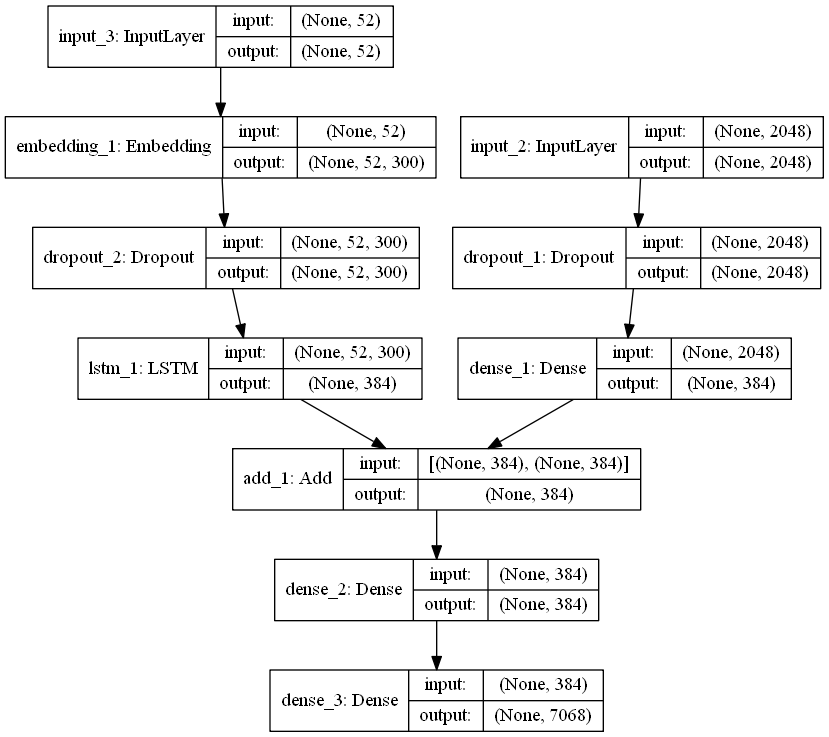

In [39]:
# Plot to visualize the structure of the network created above
plot_model(model, to_file='model.png', show_shapes=True)

In [40]:
model.layers[2]

Before moving towards compilation of model, we need to include the embedded matrix from a pre-trained Glove model that we created above. 

In [41]:
# Load the weights of matrix
model.layers[2].set_weights([embedding_matrix])
# Freeze the layer untrainable to avoid the updation during the backpropagation while training the model
model.layers[2].trainable = False

In [42]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

Finally the weights of the model will be updated through back propagation algorithm and the model will learn to output a word, given an image feature vector and a partial caption.

At this point, we required to store the entire dataset in the memory, but the vector size is huge that it is not possible to do that at once. Even if we can do that, it will kill the system speed. To avoid this problem we can use generator. This means that we do not require to store the entire dataset in the memory at once. Even if we have the current batch of points in the memory, it is sufficient for our purpose.

Following we will define the generator.

In [43]:
# I took this code from "https://github.com/hlamba28/Automatic-Image-Captioning"
# Data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while True:
        for row in train_df.iterrows():
            image_id = row[1][0]
            caption_list = row[1][1]
            n+=1
            # retrieve the photo feature
            photo = row[1][2]
            for caption in caption_list:
                # encode the sequence
                seq = []
                for word in caption.split(' '):
                    if word in word_to_index.keys():
                        seq.append(word_to_index[word])
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, value=0, padding="post")[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=(len(word_to_index)+1))[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [40]:
# As the training of model was computationally haevy, therefore load the weights saved in last training
# model.load_weights("model_300d_384neuron_40drput3.h5")

<a id="t12"></a>

### Train the model

In [44]:
# Define the number of images to be processed per batch
number_pics_per_batch = 5
# Define the number of times data generator will be called for each epoch in order to feed entire training set to model
steps = len(train_df)//number_pics_per_batch

In [45]:
#  Define a variable to store the loss of each training set
model_loss = {}
# Iterator tp train the model for the given range
for i in range(1, 4):
    
    # Call generator dunction
    generator = data_generator(train_df, word_to_index, max_train_caption_len, number_pics_per_batch)
    
    # Fit the model using generator, steps and epoch
    history = model.fit_generator(generator=generator, steps_per_epoch=steps, epochs=1)
    
    # Store the loss
    model_loss[i] = history.history['loss']
    
    # Save the trained model weightes
    model.save(f"model_300d_384neuron_40drput{i}.h5")

Epoch 1/1
23657/23657 [==============================] - 2015s 85ms/step - loss: 2.8771
Epoch 1/1
23657/23657 [==============================] - 2018s 85ms/step - loss: 2.6545
Epoch 1/1
23657/23657 [==============================] - 2024s 86ms/step - loss: 2.6392


In [46]:
# Sanity check on loss value
model_loss

{1: [2.8787652118596276], 2: [2.6563713910072053], 3: [2.641055583592675]}

In [47]:
# Save the loss calculated in pickel file
with open('model_loss_118k_1_2_3epoch_384neuron_4drput.pkl', 'wb') as f:
    pickle.dump(model_loss, f, pickle.HIGHEST_PROTOCOL)

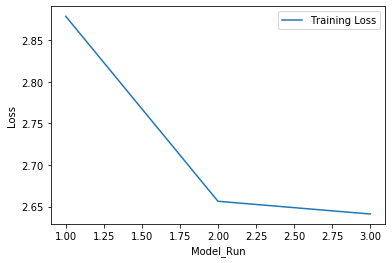

In [48]:
#  Plot the loss for each model
loss_values = [val[0] for val in model_loss.values()]
runs = [val for val in model_loss.keys()]

plt.plot(runs, loss_values)
plt.xlabel('Model_Run')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.show()

<a id="t13"></a>

### Predict the Caption

To predict the caption, I am using Beam Search and Argmax. Argmax function will predict the caption from the words with the highest probability in the word corpus. It ignores the global maxima, which refers to largest output. 

Beam Search is a heuristic search algorithm. It selects multiple alternatives for an input sequence at each time step based on conditional probability. The number of multiple alternatives depends on a parameter called Beam Width. This works by taking multiple combinations of words (in our case) for consecutive time steps and calculating which words are likely to go together based on the conditional probability. An upside of higher beam width should yield better result as the multiple candidate sequences increase the likelihood of better matching a target sequence. The downside of higher beam width is that it would use a lot of memory and computational power.

In [54]:
# Define the function to predict the caption through beam search
def beam_search_predictions(img_id, beam_width = 3):
    # Extract the index of <start> from the word_to_index
    start = [word_to_index["<start>"]]
    
    # Start the partial sequnce with the <start> sequence
    start_word = [[start, 0.0]]
    
    # Iterate while length of generated caption is less than the maximum caption length
    while len(start_word[0][0]) < max_train_caption_len:
        # create an empty list to store the list of words (captions and patial captions) and their joint probability
        temp = []
        for s in start_word:
            # Post pad the partial caption
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_train_caption_len, padding='post')
            # extract the feature vector for the image based on the image id
            img_feat = val_features[img_id].reshape((1, 2048))
            # predict the next candidates for the word in sequence
            preds = model.predict([img_feat, np.array(par_caps)])
            
            # Select the list indices (using np.argsort) of top n(beam_width) words
            word_preds = np.argsort(preds[0])[-beam_width:]

            
            # Getting the top <beam_width>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                # Append the word to list of candidates for next sequence
                next_cap.append(w)
                # Add probability of the candidate to the previous probability to get the joint probability
                prob += preds[0][w]
                # Append the caption (full or partial) along with the joint probability
                temp.append([next_cap, prob])
                    
        start_word = temp
        
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        
        # Getting the top words
        start_word = start_word[-beam_width:]
    
    # Select list indices of all the words that have the highest joint probability
    start_word = start_word[-1][0]
    
    # create a list of words from indices of words in the start_word list using index_to_word mapping that we created earlier
    intermediate_caption = [index_to_word[i] for i in start_word]

    # create an empty list to store the words of final caption
    final_caption = []
    
    # iterate through the intermediate_caption list and append each word to the
    # final_caption list until <end> sequence is reached
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    # Join the final_caption list to form a sentence
    final_caption = ' '.join(final_caption[1:])
    return final_caption

<a id="t14"></a>

### Evaluate the model output

For evaluating the final model, I applied the BLEU (Bilingual Evaluation Understudy) score that was initially proposed by Kishore Papineni in his [research paper](https://www.aclweb.org/anthology/P02-1040.pdf). BLEU compares the n-gram of the generated caption with the n-gram of the original caption to count the number of matches. These matches are independent of the positions where they occur. It lies between 0 to 1. 1 means the exact same match whereas 0 means no similar words at all. Even with the synonyms, the score tends to get down. For example:<br>
Actual cap: “A small dog is running on green grass”<br>
Predicted cap: “A small dog is running on green grass”<br>
BLEU score will be 1 because of the exact same match.<br>
But if the predicted cap is “A little dog is running on green grass”, the BLEU score will be around 0.75. Keeping that in mind, the average BLEU score for the final model is 0.58 which is pretty good against the basic model score of 0.52.

In [55]:
# evaluate the model
def evaluate_model(predicted_caption, actual_captions):
    # empty list to store tokenized actual and predicted captions
    actual, predicted = list(), list()
    # tokenize all 5 actual captions to a list
    references = [caption.split() for caption in actual_captions]
    # Append to the empty 'actual' list
    actual.append(references)
    # Tokenize the predicted caption and append to the empty 'predicted' list
    predicted.append(predicted_caption.split())
    # calculate BLEU score
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    return bleu1, bleu2, bleu3

Predicted caption = a group of people riding on the backs of elephants
Actual caption = ['A man riding on the back of an elephant through a city street.', 'Man riding on the back of a painted elephant. ', 'A man in colorful clothing riding a painted elephant.', 'a man in a white shirt is riding an elephant and some buildings', 'An old decorated elephant and its colorful rider']


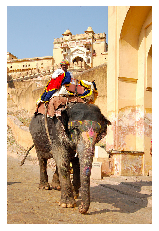

Predicted caption = a bathroom with a toilet and a sink
Actual caption = ['A white refrigerator and a counter in a room.', 'A kitchen with all the appliances such as a fridge, microwave and stove. ', 'a kitchen with a refrigerator a counter and a sink', 'A kitchen that has a large fridge and other appliances.', 'a kitchen that has a bunch of cabinets in it']


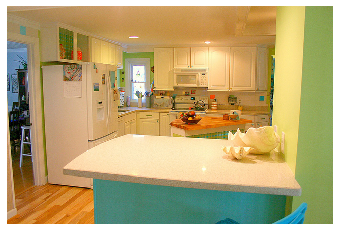

Predicted caption = a man riding a skateboard up the side of a ramp
Actual caption = ['A man doing a trick on a skateboard over some steps.', 'Guy flips his skateboard in mid air doing a trick.', 'A man doing a skateboard trick on some stairs.', 'A boy performs a skateboarding stunt in a skate park', 'A man on a skateboard jumping up in the air.']


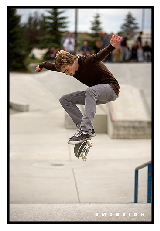

Predicted caption = a black and white photo of a fire hydrant in the middle of a street
Actual caption = ['A teddy bear in jail clothes posed on top of a trash can.', 'A giant teddy bear sitting on a garbage can', 'a teddy bear dressed in prison stripes sitting on top of a trash can', 'A large white stuffed bear sits on a trash can.', 'A white teddy bear sitting on top of a trash can.']


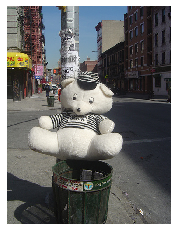

Predicted caption = a group of people that are riding an elephant
Actual caption = ['An elephant standing next to a stone in a cage.', 'An elephant playing with a sack handing from a concrete structure.', 'An elephant reaching for a ball hanging above it.', 'An elephant eating something from a hanging net.', 'an elephan standing around next to some people ']


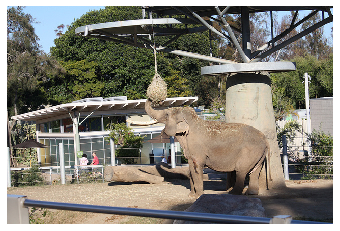

Predicted caption = a group of people that are sitting at a table
Actual caption = ['A man serving another man a cake with candles on it.', 'A man holding a cake with lit candles up to another man.', 'Man wearing red hoodie being presented with cake.', 'A man presents a cake with lit candles on it to a seated man.', 'A man is being handed a birthday cake with lit candles.']


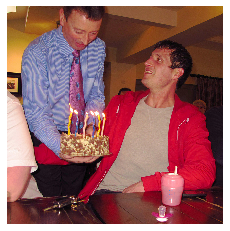

Predicted caption = a white toilet sitting in a bathroom next to a window
Actual caption = ['Partially open door leading to a kitchen from a hallway.', 'A bathroom with the lights on visible through a slightly ajar door.', 'The bathroom door has three panels of frosted glass.', 'The open door to the bathroom is shown here.', 'Outside shot of a restroom showing the door partially open.']


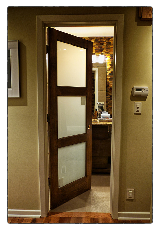

Predicted caption = a man sitting on a bench next to a bench
Actual caption = ['Set of toy animals sitting in front of a red wooden wagon.', 'Several toy animals - a bull, giraffe, deer and parakeet.', 'Some toy animals on the ground near a picture', "Children's toy animals are strewn across a floor.", 'A display of vintage animal toys on the floor.']


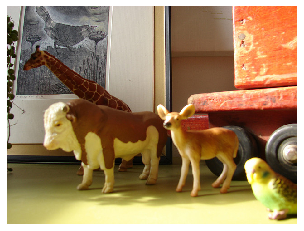

Predicted caption = a piece of chocolate cake sitting on top of a white plate
Actual caption = ['A square of cheesecake on a marble cutting board with a two-pronged fork.', 'A piece of cake sitting on a square plate.', 'A small piece of dessert sitting on a gray plate.', 'A tiny square of cake beside a two tonged fork', 'a fork and a piece of cheese cake on a gray platter']


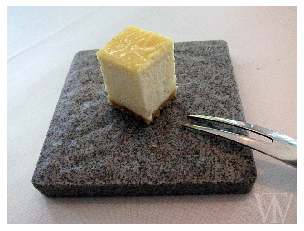

Predicted caption = a red train on a train track next to a forest
Actual caption = ['A yellow and red train traveling down train tracks.', 'A train parked at a waiting station where passengers board.', 'a brown and yellow commuter train with headlights on ', 'A passanger train stopped on the railroad tracks.', 'A passanger train stopped on the railroad tracks at a station.', 'Front view of train with lights on next to a sidewalk.', "The train has it's headlights on and is ready to leave the station."]


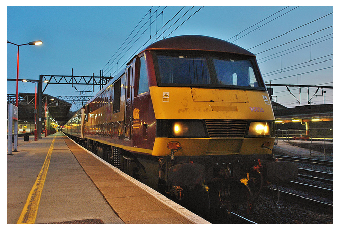

In [60]:
for i in range(10):
    rand_img_id = random.choice(list(val_df["image_id"]))
    img_path = data_path + "val2017\\" + f"{rand_img_id}.jpg"
    img = val_features[rand_img_id]
    actual_caption = val_df[val_df["image_id"] == rand_img_id]["caption"].tolist()[0]
    caption = beam_search_predictions(rand_img_id, beam_width=3)
    print(f"Predicted caption = {caption}")
    print(f"Actual caption = {actual_caption}")
    evaluate_model(caption, actual_caption)
    im = plt.imread(img_path)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [51]:
def predict_caption(img):
    # Start the sequence with <start> sequence
    in_text = "<start>"
    for i in range(max_train_caption_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_train_caption_len, padding="post")
        pred = model.predict([img, sequence])
        pred = pred.argmax()
        word = index_to_word[pred]
        in_text += (' ' + word)
        if word == "<end>":
            break
    caption = in_text.split()[1:-1]
    return ' '.join(caption)

Predicted caption = a plate of food with a fork and a fork
Actual caption = ['A plate of food featuring burger patties, potatoes and carrots. ', 'Two sausage patties, carrots and potatoes on a plate with a fork.', 'The meal on the dish is ready to be eaten. ', 'Bunless burgers are a healthy option when paired with vegetables.', 'Two burgers sit on a plate next to carrots and potatoes.']


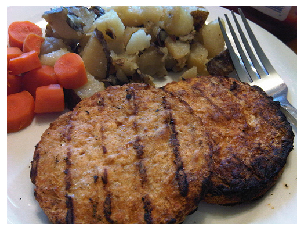

Predicted caption = a man riding a surfboard on top of a wave
Actual caption = ['A man holding a surfboard walking on a beach next to the ocean.', 'A surfer walking on a beach holding a surfboard.', 'A man walking on the beach carrying a surfboard.', 'A lone surfer carries his board next to the shore.', 'A person walking along the beach with a surfboard.']


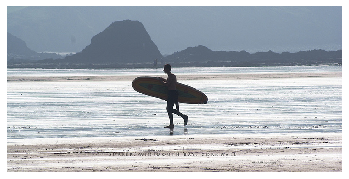

Predicted caption = a baseball player is holding a bat in his hand
Actual caption = ['A batter swings at the ball during a baseball game', 'An organized baseball match between two teams with the batter swinging', 'A man swinging a baseball bat on a baseball field.', 'A baseball player after he had swung a bat.', 'A batter swings the bat as the crowd watches attentively.']


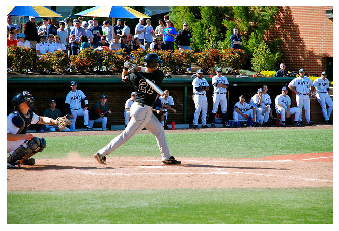

Predicted caption = a man is eating a piece of pizza
Actual caption = ['A child taking a bite of a pizza slice on a plate.', 'a little kid eating a big slice of pizza at a table ', 'I young boy eating a large piece of pizza.', 'A young boy sinking his teeth into a piece of pizza', 'A little boy sits at a table in a restaurant eating a slice of pizza.']


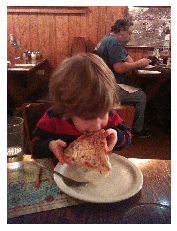

Predicted caption = a person on a snowboard in the snow
Actual caption = ['A snowboarder with black and white clothes finishing a run.', 'A man riding a snowboard down a snow covered slope.', 'A man on a snow board going down a snow covered hill.', 'This image is of a man snowboarding down a hill.', 'a ski boarder skiing down the side of a mountain.']


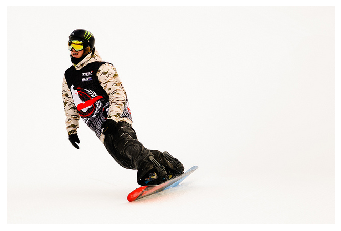

Predicted caption = a group of people sitting at a table with a cake
Actual caption = ['A group of people watching a woman cutting a cake.', 'some people and two women are cutting a white cake', 'People watching as a woman cuts into a cake.', 'A group of women standing around a cake sitting on top of a table.', 'A girl slicing a pie inside of a box while others watch.']


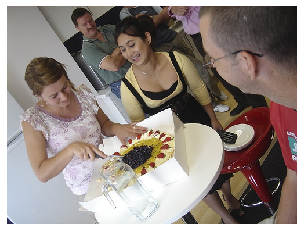

Predicted caption = a vase with flowers in it in a vase
Actual caption = ['A vase filled with flowers next to a smaller vase filled with even more flowers.', 'Two vases filled with flowers on a table.', 'Two vases of fresh flowers sit on top of the table.', 'a small vase and a large vase of flowers on a table', 'A wooden table holding two vases of flowers.']


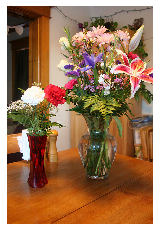

Predicted caption = a giraffe standing in a field with a tree in the background
Actual caption = ['Two giraffes grazing on some green leaves in the field.', 'Two giraffes grazing from a tree in a field.', 'GIRAFFES EATING THE SHRUBBERY OR THE TOP OF TREES', 'two giraffes eating leaves together off of a tree', 'Giraffes love the tender, young leaves on trees.']


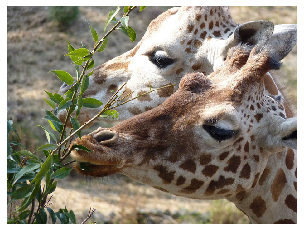

Predicted caption = a toilet with a seat and a sink
Actual caption = ['A table with a plate of food and a urinal basin', 'A urinal next to a red table with a plate sitting on the table.', 'a white urinal white tiles a red table with a dish', 'A urinal in a public restroom near a wooden table.', 'a little red tabke with a plate on it in the bathroom ']


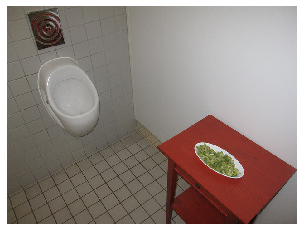

Predicted caption = a train on a track with a train on the tracks
Actual caption = ['A blue and white train is moving on the rails. ', 'A five car blue and white train with passengers', 'An electric train is traveling down the track on a road.', 'A close-up of an electric train going by on the tracks.', 'A large white and blue train on a train track.']


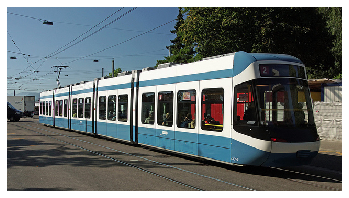

In [58]:
# Testing
for i in range(10):
    rand_img_id = random.choice(list(val_df["image_id"]))
    img_path = data_path + "val2017\\" + f"{rand_img_id}.jpg"
    img = val_features[rand_img_id].reshape((1, 2048))
    actual_caption = val_df[val_df["image_id"] == rand_img_id]["caption"].tolist()[0]
    caption = predict_caption(img)
    print(f"Predicted caption = {caption}")
    print(f"Actual caption = {actual_caption}")
    evaluate_model(caption, actual_caption)
    im = plt.imread(img_path)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [53]:
beam3_bleu1s = []
beam3_bleu2s = []
beam3_bleu3s = []

beam5_bleu1s = []
beam5_bleu2s = []
beam5_bleu3s = []

beam7_bleu1s = []
beam7_bleu2s = []
beam7_bleu3s = []

argmax_bleu1s = []
argmax_bleu2s = []
argmax_bleu3s = []

for i in tqdm(range(100)):
    rand_img_id = random.choice(list(val_df["image_id"]))
    img_path = data_path + "val2017\\" + f"{rand_img_id}.jpg"
    img = val_features[rand_img_id].reshape((1, 2048))
    actual_caption = val_df[val_df["image_id"] == rand_img_id]["caption"].tolist()[0]
    beam3_caption = beam_search_predictions(rand_img_id, beam_width=3)
    beam5_caption = beam_search_predictions(rand_img_id, beam_width=5)
    beam7_caption = beam_search_predictions(rand_img_id, beam_width=7)
    argmax_caption = predict_caption(img)
    print(f"Beam k=3 Predicted caption = {beam3_caption}")
    print(f"Beam k=5 Predicted caption = {beam5_caption}")
    print(f"Beam k=7 Predicted caption = {beam7_caption}")
    print(f"Argmax Predicted caption = {argmax_caption}")
    print("Actual caption = [" + ('\n'.join(actual_caption)) + "]")
    beam3_bleu1, beam3_bleu2, beam3_bleu3 = evaluate_model(beam3_caption, actual_caption)
    beam3_bleu1s.append(beam3_bleu1)
    beam3_bleu2s.append(beam3_bleu2)
    beam3_bleu3s.append(beam3_bleu3)
    
    beam5_bleu1, beam5_bleu2, beam5_bleu3 = evaluate_model(beam5_caption, actual_caption)
    beam5_bleu1s.append(beam5_bleu1)
    beam5_bleu2s.append(beam5_bleu2)
    beam5_bleu3s.append(beam5_bleu3)
    
    beam7_bleu1, beam7_bleu2, beam7_bleu3 = evaluate_model(beam7_caption, actual_caption)
    beam7_bleu1s.append(beam7_bleu1)
    beam7_bleu2s.append(beam7_bleu2)
    beam7_bleu3s.append(beam7_bleu3)
    
    argmax_bleu1, argmax_bleu2, argmax_bleu3 = evaluate_model(argmax_caption, actual_caption)
    argmax_bleu1s.append(argmax_bleu1)
    argmax_bleu2s.append(argmax_bleu2)
    argmax_bleu3s.append(argmax_bleu3)

print(f"Beam with k=3 Avg BLEU-1 score: {sum(beam3_bleu1s)/len(beam3_bleu1s)}")
print(f"Beam with k=3 Avg BLEU-2 score: {sum(beam3_bleu2s)/len(beam3_bleu2s)}")
print(f"Beam with k=3 Avg BLEU-3 score: {sum(beam3_bleu3s)/len(beam3_bleu3s)}")

print(f"Beam with k=5 Avg BLEU-1 score: {sum(beam5_bleu1s)/len(beam5_bleu1s)}")
print(f"Beam with k=5 Avg BLEU-2 score: {sum(beam5_bleu2s)/len(beam5_bleu2s)}")
print(f"Beam with k=5 Avg BLEU-3 score: {sum(beam5_bleu3s)/len(beam5_bleu3s)}")

print(f"Beam with k=7 Avg BLEU-1 score: {sum(beam7_bleu1s)/len(beam7_bleu1s)}")
print(f"Beam with k=7 Avg BLEU-2 score: {sum(beam7_bleu2s)/len(beam7_bleu2s)}")
print(f"Beam with k=7 Avg BLEU-3 score: {sum(beam7_bleu3s)/len(beam7_bleu3s)}")

print(f"Argmax Avg BLEU-1 score: {sum(argmax_bleu1s)/len(argmax_bleu1s)}")
print(f"Argmax Avg BLEU-2 score: {sum(argmax_bleu2s)/len(argmax_bleu2s)}")
print(f"Argmax Avg BLEU-3 score: {sum(argmax_bleu3s)/len(argmax_bleu3s)}")

Beam k=3 Predicted caption = a man in a suit and tie standing in front of a window
Beam k=5 Predicted caption = a group of people that are standing in the grass
Beam k=7 Predicted caption = a couple of people that are standing in the grass
Argmax Predicted caption = a man in a suit and tie is holding a cell phone
Actual caption = [Not really a good choice for this shirt and tie combination.
A man has a checked shirt and striped tie.
A man wearing a collar shirt with a blue tie
A man wearing a shirt and a pixilated looking neck tie.
A young man is taking a "selfie" of himself. ]
Beam k=3 Predicted caption = a man riding on the back of a brown horse
Beam k=5 Predicted caption = a couple of men riding on the backs of horses
Beam k=7 Predicted caption = a couple of men riding on the backs of horses
Argmax Predicted caption = a man riding on the back of a brown horse
Actual caption = [A man riding a horse drawn carriage on a race track.
A young man riding in a cart attached to a horse.
A ho

Beam k=3 Predicted caption = a passenger train that is going down the tracks
Beam k=5 Predicted caption = there is a train that is traveling down the tracks
Beam k=7 Predicted caption = there is a train that is coming down the tracks
Argmax Predicted caption = a train is on the tracks in a city
Actual caption = [A train traveling down train tracks near a train station.
A train running along a track near a station.
A train that is riding on tracks through a station.
A passenger train that is pulling into a station.
A train on its tracks with a Mannheim sign on the front.]
Beam k=3 Predicted caption = a herd of sheep standing next to each other on a lush green field
Beam k=5 Predicted caption = a herd of sheep standing next to each other on a lush green field
Beam k=7 Predicted caption = a herd of sheep standing next to each other on a lush green field
Argmax Predicted caption = a herd of sheep standing next to each other in a field
Actual caption = [a small sheep is standing in a pin
Th

Beam k=3 Predicted caption = a traffic light on a city street in front of buildings
Beam k=5 Predicted caption = a traffic light in front of a traffic light
Beam k=7 Predicted caption = a traffic light in front of a traffic light
Argmax Predicted caption = a traffic light with a clock on it
Actual caption = [A green traffic light suspended above a street.
A double traffic signal shows three green lights.
Two green lit traffic lights with a blue sky behind them.
Green lights a shining bright against a cool blue sky.
The traffic lights glow green in the night sky.]
Beam k=3 Predicted caption = a person holding a hot dog in front of a window
Beam k=5 Predicted caption = a person holding a hot dog in front of a window
Beam k=7 Predicted caption = a person holding a hot dog in front of a pizza
Argmax Predicted caption = a man holding a hot dog in a bun
Actual caption = [A little kid holding up two hot dogs in buns.
A boy standing in front of his class holding a hot dog in each hand.
A child

Beam k=3 Predicted caption = a bunch of bananas sitting on top of a table
Beam k=5 Predicted caption = a close up of a bunch of bananas on a table
Beam k=7 Predicted caption = a close up of a bunch of bananas on a table
Argmax Predicted caption = a banana and a banana on a table
Actual caption = [A bunch of bananas sitting on top of a wooden table.
A closeup of a group of bananas on a table 
The four huge bananas are still connected together.
Close up of a bunch of bananas on a wooden counter.
A bunch of bananas very close up on a table.]
Beam k=3 Predicted caption = a group of people riding bikes down a street next to a street
Beam k=5 Predicted caption = a couple of people riding bikes down a street next to a street
Beam k=7 Predicted caption = a black and white photo of some people walking down a street
Argmax Predicted caption = a man riding a bike down a street next to a street
Actual caption = [a person riding on a bicycle on the street in front of some cars
The cars are travelli

Beam k=3 Predicted caption = a group of people that are playing a game
Beam k=5 Predicted caption = a group of people that are playing a game
Beam k=7 Predicted caption = a group of people that are playing a game
Argmax Predicted caption = a group of people standing around a large group of people
Actual caption = [A group of three men standing next to each other on a baseball field.
A man wearing a white shirt and standing between two baseball players.
a black and white picture of tow baseball players and a coach 
A man talking to two people in baseball uniforms.
Two old time baseball players talk to a man.]
Beam k=3 Predicted caption = a group of elephants that are standing in the dirt
Beam k=5 Predicted caption = a herd of elephants standing on top of a lush green grass covered field
Beam k=7 Predicted caption = a herd of elephants standing on top of a lush green field
Argmax Predicted caption = a group of elephants standing in a field
Actual caption = [A herd of elephants standing o

Beam k=3 Predicted caption = a group of people that are posing for a picture
Beam k=5 Predicted caption = a group of people that are posing for a picture
Beam k=7 Predicted caption = a group of people that are posing for a picture
Argmax Predicted caption = a group of people standing around a tennis court
Actual caption = [A man is taking a photo of a city with his phone.
A man taking a picture of the city with his cellphone.
The man in the business suit takes a video of city buildings.
A man in suit taking a photograph with a cellphone.
A business man photographs a city with his cell phone.]
Beam k=3 Predicted caption = a group of people standing on top of a sandy beach
Beam k=5 Predicted caption = a group of people standing on top of a sandy beach
Beam k=7 Predicted caption = a group of people that are standing in the water
Argmax Predicted caption = a man is riding a surfboard on the water
Actual caption = [A man and woman bathe in a shallow river.
A man and a woman in a river.
A ma

Beam k=3 Predicted caption = a group of people riding skis down a snow covered slope
Beam k=5 Predicted caption = a group of people riding skis down a snow covered slope
Beam k=7 Predicted caption = a group of people riding skis down a snow covered slope
Argmax Predicted caption = a man on skis is standing in the snow
Actual caption = [A group of people on the ski slope in their skis. 
A group of young people standing on top of a snow covered slope.
A group of people on skis at a peak of a mountain.
The skiers are happy to pose for the picture.
a group of people riding skis on a snowy surface]
Beam k=3 Predicted caption = a red double decker bus driving down a street
Beam k=5 Predicted caption = there is a double decker bus that is driving down the street
Beam k=7 Predicted caption = a double decker bus that is driving down the street
Argmax Predicted caption = a bus is driving down the street in front of a building
Actual caption = [A library bus outside of an apartment building
The l

Predicted caption = a man on a skateboard riding on a ramp


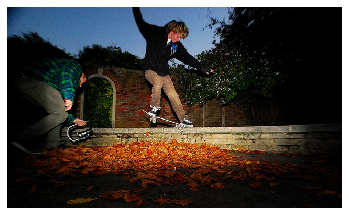

Predicted caption = a giraffe standing in a field with a tree in the background


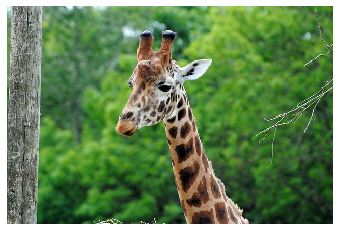

Predicted caption = a surfer riding a wave in the ocean


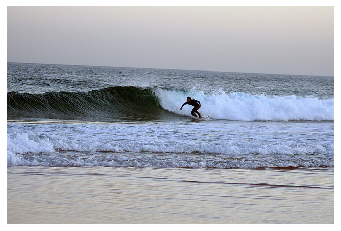

Predicted caption = a living room with a couch and a television


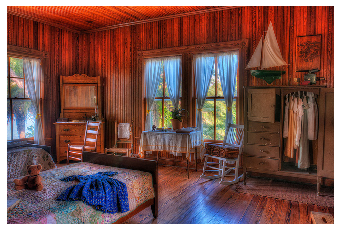

Predicted caption = a clock tower with a clock on it s side


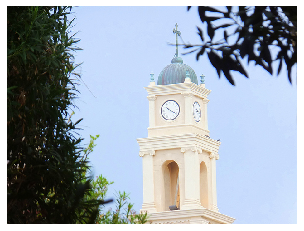

Predicted caption = a clock tower with a clock on the top of it


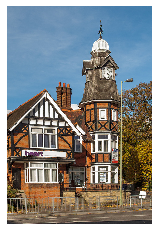

Predicted caption = a man riding a horse down a street


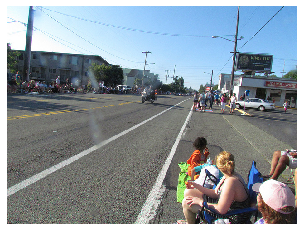

Predicted caption = a group of people sitting around a table with a cake


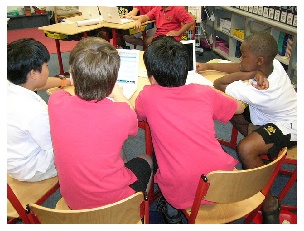

Predicted caption = a person on skis is going down a hill


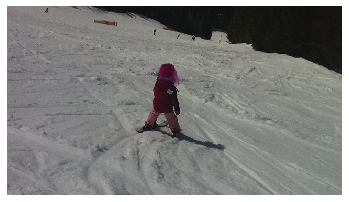

Predicted caption = a group of people sitting on a bench near a body of water


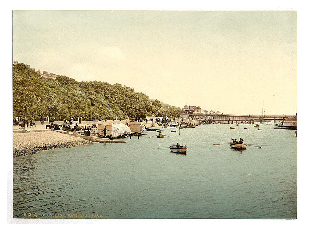

In [76]:
test_files = glob2.glob(os.path.join((data_path + "test2017\\"), "*.jpg"))
for test_img in test_files[21:31]:
    feat_vect = encode_image(test_img).reshape((1, 2048))
    caption = predict_caption(feat_vect)
    print(f"Predicted caption = {caption}")
    im = plt.imread(test_img)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

<a id="t15"></a>

**Conclusion:** Looking at the BLEU score, we can conclude that ArgMax provides us with better results which are closer to actual captions. This algorithm is computationally less expensive as well, hence choosing this makes sense.<br>
We were able to generate meaningful captions for images that were never seen by the model during training (from test set).